In [24]:
import numpy as np
import matplotlib.pyplot as plt

import re

# Harmonic oscillator data

In [8]:
filename = "C-code/integration_results.dat"
n_coords = 3
coordinates = {}

In [9]:
def x_f(t, x0, y0, w):
    return y0/w * np.sin(w*t) + x0*np.cos(w*t)
def y_f(t, x0, y0, w):
    return y0*np.cos(w*t) - x0*w*np.sin(w*t)

In [12]:
coordinates = {}

with open(filename, 'r') as rfile:
    lines = rfile.readlines()
    new_point_pattern = r"New point coordinate ([0-9]+)"
    basic_coordinates_pattern = r"(-*[0-9]*\.*[0-9]*e*[+-]*[0-9]+) "
    coordinates_pattern = ""

    for i in range(n_coords):
        coordinates_pattern += basic_coordinates_pattern
    
    current_name = "none"
    for line in lines:
        match_point = re.match(new_point_pattern, line)
        match_coord = re.match(coordinates_pattern, line)

        if match_point: # building the structure to hold the datapoints [ [ti], [xi], ...]
            current_name = match_point.groups()[0]
            coordinates[current_name] = []
            for i in range(n_coords):
                coordinates[current_name].append([])
            pass
        elif match_coord:
            if len(match_coord.groups()) != n_coords:
                print("Coordinate length mismatch ", match_coord.groups())
                print(line)
                break
            for i in range(n_coords):
                coordinates[current_name][i].append(float(match_coord.groups()[i]))
        else:
            continue

print("Threads: ", len(coordinates))
n_threads  = len(coordinates)


Threads:  128


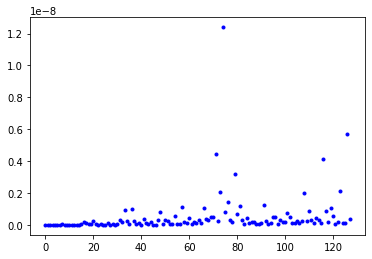

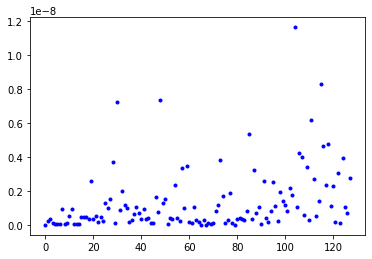

In [13]:
x_err_arr = []
y_err_arr = []

for id in range(n_threads):

    # id = 5
    # point_id = 5

    point_name = str(id)

    w = 2*np.pi

    # changing the initial position depending on the simulation
    x0 = 0 + (1.0*id)/n_threads
    y0 = 1 + -(1.0*id)/n_threads

    t_arr = coordinates[point_name][0]
    x_arr = coordinates[point_name][1]
    y_arr = coordinates[point_name][2]

    x_sol = [x_f(t, x0, y0, w) for t in t_arr]
    y_sol = [y_f(t, x0, y0, w) for t in t_arr]

    x_err2 = 0
    y_err2 = 0
    for i, t in enumerate(t_arr):
        x_err2 += (x_arr[i]-x_sol[i])**2
        y_err2 += (y_arr[i]-y_sol[i])**2
    x_err2 /= len(t_arr)
    y_err2 /= len(t_arr)
    
    plt.scatter(t_arr, x_arr, label="x sim")
    plt.plot(t_arr, x_sol, label="x sol", color='r')
    plt.legend()
    plt.show()
    plt.scatter(t_arr, y_arr, label="y sim")
    plt.plot(t_arr, y_sol, label="y sol", color='r')
    plt.legend()
    plt.show()
    
    print("Simulation id: ", id)
    print("x_err2: ",x_err2)
    print("y_err2: ", y_err2)
    x_err_arr.append(x_err2)
    y_err_arr.append(y_err2)

plt.plot(x_err_arr, 'b.')
plt.show()
plt.plot(y_err_arr, 'b.')
plt.show()

In [11]:
2**14

16384

In [74]:
(2*np.pi)**2

39.47841760435743

# Wormhole Simulation

## Essential imports and functions

In [44]:
import ipyvolume as ipv
from scipy import integrate
from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection


In [3]:
def z_integrand(l):
    x = 2/(np.pi*M) * (np.abs(l)-a)
    return np.sqrt(1-(2/np.pi)**2*np.arctan(x)**2)

def z_l(l):
    return integrate.quad(z_integrand, 0, l)[0]

def r_l(l):
    x = 2*(np.abs(l)-a)/(np.pi*M)
    if np.abs(l)>a:
        r = rho + M * (x*np.arctan(x) - 1/2*np.log(1+x**2))
        # drdl = 2/(np.pi)*np.arctan(x)*np.sign(l) 
    else:
        r = rho
    return r

In [4]:
def gen_metric_links(L, L_iter, phi_iter):
    x_cord = []
    y_cord = []
    z_cord = []

    for l in np.linspace(-L, L, L_iter):
        for phi in np.linspace(0, 2*np.pi, phi_iter):
            r = r_l(l)
            x = r*np.cos(phi)
            y = r*np.sin(phi)
            z = z_l(l)
            x_cord.append(x)
            y_cord.append(y)
            z_cord.append(z)

    triangle_links1 = []
    triangle_links2 = []
    line_links = []

    for j in range(L_iter-1):
        for i in range(int(phi_iter)):
            N = phi_iter
            triangle_links1.append([i+j*N, (i+1)+j*N, i+(j+1)*N])
            triangle_links2.append([i+j*N,  (i-1)+(j+1)*N,i+(j+1)*N])

            if i+1+j*N <= L_iter*phi_iter:
                line_links.append([i+j*N, i+1+j*N])
            if i+(j+1)*N <= L_iter*phi_iter:
                line_links.append([i+j*N, i+(j+1)*N])
    
    return (x_cord, y_cord, z_cord, triangle_links1, triangle_links2, line_links)


## Selecting basic parameters for file import

In [5]:
filename = "C-code/integration_results/wormhole_integration_results.dat"
n_coords = 6
n_params = 5

coordinates = {}
params = {}

## Importing data from simulation

In [21]:
coordinates = {}
params = {}

with open(filename, 'r') as rfile:
    lines = rfile.readlines()
    number_pattern = r"(-*[0-9]*\.*[0-9]*e*[+-]*[0-9]+)\t"
    new_point_pattern = r"New point coordinate (.*); params:\t"+number_pattern*n_params+"\n"
    coordinates_pattern = number_pattern*n_coords + "\n"

    current_name = "none"
    for line in lines:
        match_point = re.match(new_point_pattern, line)
        match_coord = re.match(coordinates_pattern, line)

        if match_point: # building the structure to hold the datapoints [ [ti], [xi], ...]
            current_name = match_point.groups()[0]
            coordinates[current_name] = []
            params[current_name] = []
            for i in range(n_coords):
                coordinates[current_name].append([])
            for j in range(n_params):
                params[current_name].append(match_point.groups()[j+1])
            pass
        elif match_coord:
            if len(match_coord.groups()) != n_coords:
                print("Coordinate length mismatch ", match_coord.groups())
                print(line)
                break
            for i in range(n_coords):
                coordinates[current_name][i].append(float(match_coord.groups()[i]))
        else:
            continue

print("Threads: ", len(coordinates))
n_threads  = len(coordinates)


Threads:  128


## Displaying light paths in 3D


In [23]:

ipv.figure()

for id in range(0,n_threads,8):
    # id = 6
    name = str(id)

    # print("Parameters: ")
    # print("M: ", params[name][0])
    # print("a: ", params[name][1])
    # print("rho: ", params[name][2])
    # print("b (pphi): ", params[name][3])
    # print("B: ", params[name][4])

    M = float(params[name][0])
    a = float(params[name][1])
    rho = float(params[name][2])

    L = 500
    L_iter = 30
    phi_iter = 30

    x_c, y_c, z_c, _, _, line_lk = gen_metric_links(L, L_iter, phi_iter)

    l_arr = np.array(coordinates[name][1])
    phi_arr = np.array(coordinates[name][3])
    r_arr = np.array([r_l(l) for l in l_arr])

    x_arr = r_arr * np.cos(phi_arr)
    y_arr = r_arr * np.sin(phi_arr)
    z_arr = np.array([z_l(l) for l in l_arr])

    ipv.plot_trisurf(x_c, y_c, z_c,
            lines=line_lk, color="#8100cc")
    ipv.scatter(x_arr,y_arr,z_arr,size=1)

ipv.xlim(-400,400)
ipv.ylim(-400,400)
ipv.zlim(-200,200)
ipv.show()

# break

## Showing simulated light path

/home/raul/.local/share/virtualenvs/GR-Wormholes-dWY3gXb8/lib/python3.9/site-packages/matplotlib/patches.py:1188: RuntimeWarning: divide by zero encountered in true_divide
  v2 = arc.vertices[::-1] * (self.r - self.width) / self.r
/home/raul/.local/share/virtualenvs/GR-Wormholes-dWY3gXb8/lib/python3.9/site-packages/matplotlib/patches.py:1188: RuntimeWarning: invalid value encountered in true_divide
  v2 = arc.vertices[::-1] * (self.r - self.width) / self.r
/home/raul/.local/share/virtualenvs/GR-Wormholes-dWY3gXb8/lib/python3.9/site-packages/matplotlib/patches.py:1201: RuntimeWarning: invalid value encountered in multiply
  v *= self.r


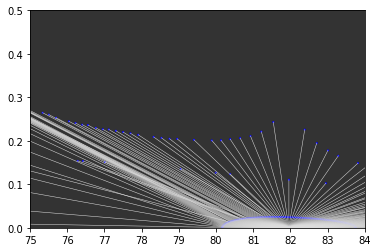

In [144]:
fig, ax = plt.subplots()
ax.set_facecolor("#333333")

shapes1 = []

for l in range(0, L, L_iter):
    shapes1.append(Wedge((0,0),l, 0,360, width=1 ))
    # colors.append('b')

# shapes1.append(Wedge((0,0),rho, 0,360, width=1 ))

# colors = 100 * np.random.rand(len(shapes))
p = PatchCollection(shapes1, facecolor='#f0f0f0', edgecolor='None')
# p1 = PatchCollection([Wedge((0,0),15, 0,360, width=1 )], facecolor='#000000')
# p.set_array(colors)
ax.add_collection(p)
# ax.add_collection(p1)
# ax.set_aspect(1)

plt.xlim(75,84)
plt.ylim(0,0.5)


for id in range(0,n_threads):
    # id = 6
    name = str(id)

    # print("Parameters: ")
    # print("M: ", params[name][0])
    # print("a: ", params[name][1])
    # print("rho: ", params[name][2])
    # print("b (pphi): ", params[name][3])
    # print("B: ", params[name][4])

    M = float(params[name][0])
    a = float(params[name][1])
    rho = float(params[name][2])

    l_arr = np.array(coordinates[name][1][:3])
    phi_arr = np.array(coordinates[name][3][:3])
    r_arr = np.array([r_l(l) for l in l_arr])

    x_arr = r_arr * np.cos(phi_arr) 
    y_arr = r_arr * np.sin(phi_arr)
    # z_arr = np.array([z_l(l) for l in l_arr])

    plt.plot(x_arr, y_arr,c='#dddddd', lw=0.5)
    plt.scatter(x_arr, y_arr, c=['b' if l>0 else 'r' for l in l_arr], s=1)

plt.show()

In [94]:
x_arr

array([ 81.95771196,  80.20284778,  70.852966  ,  55.40633116,
        18.34900831,  43.29868959, 139.07290417, 296.25406959,
       668.46468838])